In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
from datetime import datetime
import pandas as pd

import mark_backtest_underpar as mark
import globeop_reports as ops

In [47]:
#exclude sell price that are over 200
df_long = mark.back_test('2013-01-01', '2018-01-01', sell_price_threshold = 200)

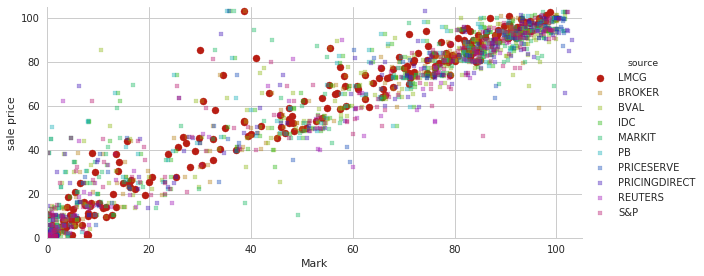

In [48]:
#%matplotlib nbagg
%matplotlib inline
mark.pretty_plot(df_long)
#file saved in serenitas shared drive/edwin/

In [49]:
#exclude trades that are over 5x mark for purpose of regression
diff_threshold = 5
results = mark.stats(df_long, diff_threshold)

In [50]:
#Regression Intercept
round(results[0],1)

Intercept  mark
source                        
BROKER               7.9   0.9
BVAL                11.1   0.9
IDC                  9.6   0.9
LMCG                 8.3   1.0
MARKIT              16.2   0.8
PB                  10.7   0.9
PRICESERVE          15.0   0.8
PRICINGDIRECT        9.9   0.9
REUTERS              5.9   0.9
S&P                  8.8   0.9

In [51]:
#Sale Difference
round(results[1],3)

source              BROKER   BVAL    IDC   LMCG  MARKIT     PB  PRICESERVE  \
average              0.263  0.280  0.354  0.321   0.347  0.331       0.524   
standard deviation   0.670  0.737  0.916  0.657   0.851  0.845       1.092   

source              PRICINGDIRECT  REUTERS    S&P  
average                     0.244    0.451  0.296  
standard deviation          0.877    0.925  0.833

In [52]:
#Now Calculate alternate valuation methodologies
df = mark.get_mark_df()

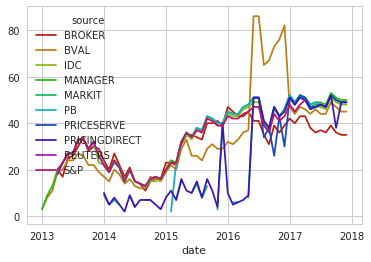

In [53]:
%matplotlib inline
mark.count_sources(df)

In [54]:
#difference by source
nav = ops.get_net_navs()['endbooknav']
difference = mark.diff_by_source_percentage(df)
#difference.to_clipboard()

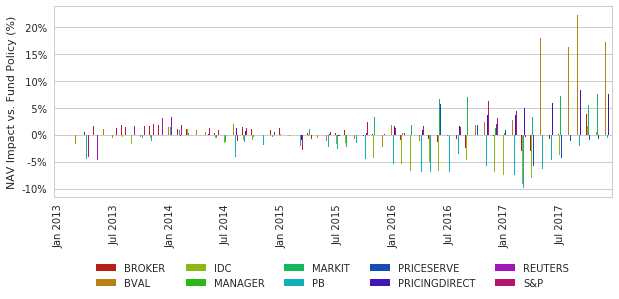

In [55]:
#plot
ax = difference.plot(kind = 'bar', legend = True, figsize = [10, 3.5])

visible = ax.xaxis.get_ticklabels()[::6]
for label in ax.xaxis.get_ticklabels():
    if label not in visible:
        label.set_visible(False)
        
ax.xaxis.set_major_formatter(plt.FixedFormatter(difference.index.to_series().dt.strftime("%b %Y")))
ax.set_ylabel('NAV Impact vs. Fund Policy (%)')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_xlabel('')
ax.grid(False, which='major',axis = 'x')
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.3),  shadow=True, ncol=5)
ax.figure.savefig("/home/serenitas/edwin/PythonGraphs/Valuation_2.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [56]:
results = mark.alt_navs()

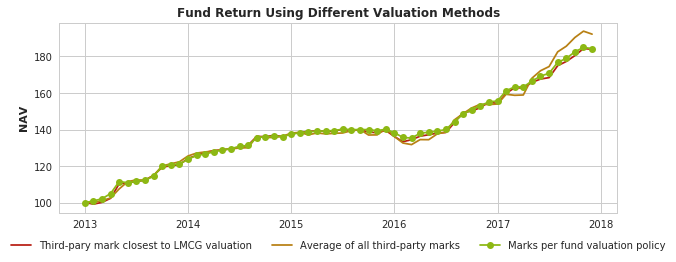

In [57]:
#%matplotlib nbagg
to_plot = ['mark_closest_all', 'mark_mean_all']
to_plot1 = ['mark_manager']
plot_df0 = results[1][to_plot]
plot_df1 = results[1][to_plot1]

plot_df0 = plot_df0.rename(columns = {'mark_closest_all': 'Third-pary mark closest to LMCG valuation', \
                                    'mark_mean_all': 'Average of all third-party marks'})
plot_df1 = plot_df1.rename(columns = {'mark_manager': 'Marks per fund valuation policy'})

ax = plot_df0.plot(figsize = [10, 3.5])
ax = plot_df1.plot(marker = 'o', ax = ax)
plt.rcParams["font.family"] = "sans-serif"
ax.set_xlabel('')
ax.set_ylabel('NAV', weight = 'bold')
ax.set_title('Fund Return Using Different Valuation Methods', weight = 'bold')
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.1),  shadow=True, ncol=3)
ax.figure.savefig("/home/serenitas/edwin/PythonGraphs/Valuation_1.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [58]:
#Fund cumulative returns from the last 12 months
results[1]['mark_manager'][-12:]

date
2017-01-31    155.659
2017-02-28    161.233
2017-03-31    163.364
2017-04-30    163.298
2017-05-31    166.464
2017-06-30    169.261
2017-07-31     170.79
2017-08-31    176.764
2017-09-30    178.941
2017-10-31    182.531
2017-11-30    184.944
2017-12-31    184.296
Name: mark_manager, dtype: object

In [59]:
round(mark.annual_performance(results[1])*100,2)

mark_mean_all  mark_manager  mark_median_all  mark_closest_all  \
date                                                                         
2013-12-31          22.34         21.11            21.78             20.76   
2014-12-31          11.39         12.44            11.79             12.77   
2015-12-31           3.13          2.95             0.69              2.45   
2016-12-31           9.34         10.65             9.58             11.17   
2017-12-31          25.07         18.82            25.21             18.61   

            mark_filtered_mean  mark_filtered_median  mark_filtered_no_max_min  
date                                                                            
2013-12-31               22.48                 22.34                     22.22  
2014-12-31               11.12                 10.87                     11.27  
2015-12-31                3.15                  0.42                      1.93  
2016-12-31                9.18                  9.66                      8.94  
2017-12-31               25.73                 25.99                     26.08

In [60]:
#A positive impact % means the alternative methodology results in a higher NAV than the fund's valuation policy.
round(pd.DataFrame(mark.alt_nav_impact())*100,2)

2017-12-31
mark_mean_all                   4.23
mark_manager                    0.00
mark_median_all                 2.10
mark_closest_all                0.08
mark_filtered_mean              4.67
mark_filtered_median            2.23
mark_filtered_no_max_min        3.42
endbooknav                    100.00

In [62]:
pnl_breakdown = ops.curr_port_PNL()

In [63]:
#Unrealized MTM Gains/Loss
breakdown_summary = pd.DataFrame(index = {'unreal mark-to-market'}, columns={'Gains','Loss','Net'})
breakdown_summary['Gains'] = pnl_breakdown[pnl_breakdown['mtdbookunrealmtm']>=0].sum()['mtdbookunrealmtm']
breakdown_summary['Loss'] = pnl_breakdown[pnl_breakdown['mtdbookunrealmtm']<0].sum()['mtdbookunrealmtm']
breakdown_summary['Net'] = pnl_breakdown.sum()['mtdbookunrealmtm']

In [64]:
breakdown_summary / nav[-1]

Loss       Net     Gains
unreal mark-to-market -0.008971  0.024987  0.033958

In [69]:
df = ops.trade_performance()
df = df.set_index('trade_date')
df.days_held = df.days_held.dt.days
winner = df[df.percent_gain > 0]
df[df.days_held.notnull()].groupby(pd.Grouper(freq='A')).mean()

id  buysell    faceamount      price   accrued  \
trade_date                                                             
2013-12-31  1.000010e+07    False  3.076243e+06  40.911075  0.059134   
2014-12-31  1.000023e+07    False  3.484545e+06  69.922735  0.068171   
2015-12-31  1.042055e+06    False  3.798581e+06  69.527018  0.090903   
2016-12-31  5.408600e+02    False  8.123439e+06  60.971575  0.170445   
2017-12-31  6.421852e+02    False  6.382841e+06  98.668843  0.117950   

            principal_payment  accrued_payment  mtdbookunrealmtm  \
trade_date                                                         
2013-12-31      296393.020434       594.013248     -1.723066e-13   
2014-12-31      451702.362327       381.613812     -1.960784e-04   
2015-12-31      614305.438948       645.517821     -1.041667e+03   
2016-12-31      420749.234186      1646.176886      1.563194e-13   
2017-12-31      742056.024711      1234.290701     -2.196644e+02   

            mtdbookrealmtm  mtdbookrealincome  mtdbookunrealincome  \
trade_date                                                           
2013-12-31    50699.311944        2374.714583          -131.913472   
2014-12-31    50983.447255        5650.365294          -115.727059   
2015-12-31     6082.929583        4530.700000           -23.972708   
2016-12-31    54458.352000       16168.748200           159.319200   
2017-12-31   226385.825556       16805.782593           404.795556   

            mtdtotalbookpl  mtdtotalbookpl_at_trade_month  initialinvestment  \
trade_date                                                                     
2013-12-31    52942.113056                   64936.786389      226686.285580   
2014-12-31    56518.085294                   56557.663529      357199.758132   
2015-12-31     9547.990208                   13957.903958      527300.141933   
2016-12-31    70786.419400                   44229.832000      394671.938197   
2017-12-31   243376.739259                  209233.875556      578843.406367   

            percent_gain   days_held  
trade_date                            
2013-12-31      0.429660   59.458333  
2014-12-31      0.520216  144.294118  
2015-12-31      0.299134  129.312500  
2016-12-31      0.646151  253.780000  
2017-12-31      1.363980  323.777778